In [1]:
import os.path

import torch
import wandb
import torchvision
from torchvision.transforms import ToTensor, RandomAffine, RandomErasing
from torch import nn, optim, utils
from torch.utils.data import DataLoader
from torch.nn.utils import clip_grad_norm_
from torchvision.datasets import MNIST
import torch.nn.functional as F
from torch_ema import ExponentialMovingAverage
from tqdm.notebook import tqdm
from safetensors.torch import save_file, load_file


# Customs
from helpers import load_encoded_dataset, encode_dataset
from helpers import rk4_step, integrate_path, warp_time, BasicModel
from helpers import plot_latent_space, comparative_generate_samples, plot_generated, create_model_suffix, load_checkpoint

from models import ResNetVAE, log_example_images, InspoResNetVAE
from models import SimpleFlowModel, FlatVelocityNet, ConvFlowNet
from models import test_inference, test_inference_spatial

from flow_train.train import train as flow_train

C:\Users\ocrab\AppData\Roaming\Python\Python313\site-packages\pydantic\_internal\_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
C:\Users\ocrab\AppData\Roaming\Python\Python313\site-packages\pydantic\_internal\_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

model_save_path = 'models/safetensors/'

wandb.login()
wandb.finish()

wandb: Currently logged in as: marcocassar (marcocassar-belmont-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [3]:
train_transforms = torchvision.transforms.Compose([
    ToTensor(),
    # uncomment next lines for extra augmentations
    #RandomAffine(degrees=15, translate=(0.1, 0.1)),
    #RandomErasing(p=0.2, scale=(0.02, 0.1))
])
train_ds = MNIST(root='./data', train=True,  download=True, transform=train_transforms)
test_ds  = MNIST(root='./data', train=False, download=True, transform=ToTensor())
print(f"Data set lengths: train: {len(train_ds)}, test: {len(test_ds)}")

batch_size = 128
train_dl = DataLoader(train_ds, batch_size=batch_size, num_workers=2, shuffle=True, persistent_workers=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, num_workers=2, shuffle=False, persistent_workers=True)

Data set lengths: train: 60000, test: 10000


### VAE

In [4]:
project = "vae_conv_testing"
recon_criterion = F.binary_cross_entropy_with_logits

def train_vae_old(
    model, train_loader, val_loader, name=None,
    epochs=20, lr=2e-3, weight_decay=5e-5,
    beta_final=0.005, warmup_epochs=10, grad_clip=5.0, ema=0.97, spatial=False
):
    device = next(model.parameters()).device

    # ---- W&B ----
    wandb.finish()
    wandb.init(project=project, name=name, reinit='finish_previous')
    wandb.config.update({
        "epochs": epochs,
        "batch_size": batch_size,
        "learning_rate": lr,
        "model": model.__class__.__name__,
        "optimizer": "Adam",
        "device": str(device),
    })

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    global_step = 0
    train_loss_avg = None

    for epoch in range(epochs):
        model.train()

        beta = beta_final * min((epoch + 1) / warmup_epochs, 1.0)

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for batch_idx, (data, _) in enumerate(pbar):
            data = data.to(device)
            optimizer.zero_grad()

            z, x_hat, mu, log_var, z_hat = model(data)

            recon_loss = recon_criterion(x_hat, data, reduction="sum") / data.size(0)
            
            kl = -0.5 * (1 + log_var - mu.pow(2) - log_var.exp())
            kl = kl.view(kl.size(0), -1).sum(dim=1).mean()
            
            loss = recon_loss + beta * kl

            # loss, recon_loss, kl = vae_loss(data, x_hat, mu, log_var, beta)

            loss.backward()
            # if grad_clip is not None:
            #     clip_grad_norm_(model.parameters(), grad_clip)
            optimizer.step()

            train_loss_avg = loss.item() if train_loss_avg is None else ema * train_loss_avg + (1 - ema) * loss.item()

            wandb.log({
                "step": global_step,
                "train_loss_ema": train_loss_avg,
                "train_loss": loss.item(),
                "recon_loss": recon_loss.item(),
                "kl_loss": kl.item(),
                "beta": beta,
                "beta*kl": (beta * kl).item(),
            })
            global_step += 1
            pbar.set_postfix(Loss=f"{train_loss_avg:.4f}", Recon=f"{recon_loss.item():.4f}", KLw=f"{(beta*kl).item():.5f}")

        # ---- validation ----
        model.eval()
        val_loss = val_recon = val_kl = 0.0
        mu_stats = []

        with torch.no_grad():
            for data, _ in val_loader:
                data = data.to(device)
                z, x_hat, mu, log_var, z_hat = model(data)

                recon = recon_criterion(x_hat, data)
                kl = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())
                loss = recon + beta * kl

                val_loss += loss.item(); val_recon += recon.item(); val_kl += kl.item()
                mu_stats.append(mu)

        n = len(val_loader)
        val_loss /= n; val_recon /= n; val_kl /= n

        mu_all = torch.cat(mu_stats, dim=0)
        mu_mean = mu_all.mean().item(); mu_std = mu_all.std().item()

        wandb.log({
            "epoch": epoch + 1,
            "val_loss": val_loss,
            "val_recon_loss": val_recon,
            "val_kl_loss": val_kl,
            "mu_mean": mu_mean,
            "mu_std": mu_std,
        })
        # print(f"Epoch {epoch+1:02d} | beta {beta:.3f} | val {val_loss:.4f} | recon {val_recon:.4f} | KL {val_kl:.4f} | μ_mean {mu_mean:.3f} μ_std {mu_std:.3f}")

        # visualize with sigmoid at eval-time only
        log_example_images(model, val_loader.dataset, epoch + 1, spatial=spatial, n=5)

    wandb.finish()
    return val_loss

In [5]:
def train_vae(
    model, train_loader, val_loader, name=None,
    epochs=20, lr=2e-3, weight_decay=5e-5,
    beta_final=1.0, warmup_epochs=5, param_ema_decay=0.9999
):
    device = next(model.parameters()).device
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    latent_dim = model.latent_dim

    spatial = len(model.latent_shape) > 1 if hasattr(model, 'latent_shape') else False

    # W&B setup
    wandb.finish()
    wandb.init(project=project, name=name, reinit='finish_previous')

    config_dict = {
        "epochs": epochs,
        "batch_size": train_loader.batch_size,
        "learning_rate": lr,
        "model": model.__class__.__name__,
        "optimizer": "Adam",
        "device": str(device),
        "total_params": total_params,
        "latent_dim": latent_dim,
        "latent_shape": model.latent_shape,
        "param_ema_decay": param_ema_decay,
    }
    if hasattr(model, 'config'):  # Add model config if avail
        config_dict["model_config"] = model.config
    wandb.config.update(config_dict)
    
    recon_criterion = F.binary_cross_entropy_with_logits
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    ema = ExponentialMovingAverage(model.parameters(), decay=param_ema_decay)
    
    global_step = 0

    for epoch in range(epochs):
        model.train()
        beta = beta_final * min((epoch + 1) / warmup_epochs, 1.0)
        
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for batch_idx, (data, _) in enumerate(pbar):
            data = data.to(device)
            optimizer.zero_grad()
            
            z, x_hat, mu, log_var, z_hat = model(data)
            
            recon_loss = recon_criterion(x_hat, data, reduction="sum") / data.size(0)
            kl = -0.5 * (1 + log_var - mu.pow(2) - log_var.exp())
            kl = kl.view(kl.size(0), -1).sum(dim=1).mean()
            loss = recon_loss + beta * kl
            
            loss.backward()
            optimizer.step()
            ema.update()
            
            wandb.log({
                "step": global_step,
                "epoch": epoch + 1,
                "val_mode": False,
                "train_loss": loss.item(),
                "recon_loss": recon_loss.item(),
                "kl_loss": kl.item(),
                "beta": beta,
                "beta*kl": (beta * kl).item(),
            })
            global_step += 1
            pbar.set_postfix(Loss=f"{loss.item():.4f}", Recon=f"{recon_loss.item():.4f}", KLw=f"{(beta*kl).item():.5f}")
        
        # Validation with EMA parameters
        model.eval()
        val_loss = val_recon = val_kl = 0.0
        mu_stats = []
        mse_total = mae_total = ssim_total = psnr_total = 0.0
        num_samples = 0
        
        with ema.average_parameters():
            with torch.no_grad():
                for data, _ in val_loader:
                    data = data.to(device)
                    z, x_hat, mu, log_var, z_hat = model(data)
                    
                    recon = recon_criterion(x_hat, data)
                    kl = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())
                    loss = recon + beta * kl
                    
                    val_loss += loss.item()
                    val_recon += recon.item()
                    val_kl += kl.item()
                    mu_stats.append(mu)
                    
                    # Reconstruction quality metrics
                    x_hat_sigmoid = torch.sigmoid(x_hat)
                    
                    mse = F.mse_loss(x_hat_sigmoid, data, reduction='sum')
                    mse_total += mse.item()
                    
                    mae = F.l1_loss(x_hat_sigmoid, data, reduction='sum')
                    mae_total += mae.item()
                    
                    psnr = 10 * torch.log10(1.0 / (F.mse_loss(x_hat_sigmoid, data) + 1e-8))
                    psnr_total += psnr.item() * data.size(0)
                    
                    # Correlation coefficient
                    data_flat = data.view(data.size(0), -1)
                    recon_flat = x_hat_sigmoid.view(data.size(0), -1)
                    
                    data_mean = data_flat.mean(dim=1, keepdim=True)
                    recon_mean = recon_flat.mean(dim=1, keepdim=True)
                    data_centered = data_flat - data_mean
                    recon_centered = recon_flat - recon_mean
                    correlation = (data_centered * recon_centered).sum(dim=1) / (
                        torch.sqrt((data_centered**2).sum(dim=1)) * torch.sqrt((recon_centered**2).sum(dim=1)) + 1e-8
                    )
                    ssim_total += correlation.sum().item()
                    
                    num_samples += data.size(0)
        
        n = len(val_loader)
        val_loss /= n
        val_recon /= n
        val_kl /= n
        
        mse_avg = mse_total / num_samples
        mae_avg = mae_total / num_samples
        psnr_avg = psnr_total / num_samples
        ssim_avg = ssim_total / num_samples
        
        mu_all = torch.cat(mu_stats, dim=0)
        mu_mean = mu_all.mean().item()
        mu_std = mu_all.std().item()
        
        # Composite loss with complexity penalties
        param_penalty = total_params / 1e6 * 0.1
        latent_penalty = latent_dim / 100 * 0.05
        composite_loss = val_loss + param_penalty + latent_penalty
        
        wandb.log({
            "epoch": epoch + 1,
            "val_mode": True,
            "val_loss": val_loss,
            "composite_loss": composite_loss,
            "param_penalty": param_penalty,
            "latent_penalty": latent_penalty,
            "val_recon_loss": val_recon,
            "val_kl_loss": val_kl,
            "mu_mean": mu_mean,
            "mu_std": mu_std,
            "val_mse": mse_avg,
            "val_mae": mae_avg,
            "val_psnr": psnr_avg,
            "val_correlation": ssim_avg,
        })

        with ema.average_parameters():
            log_example_images(model, val_loader.dataset, epoch + 1, spatial=spatial, n=5)
    
    wandb.finish()
    return model, ema

In [6]:
specifications = {
    "latent_shape": (1,7,7),
    "base_channels": 16, 
    "blocks_per_level": 2, 
    "groups": 1
}
latent_shape = (1,7,7)
vae = InspoResNetVAE(**specifications).to(device)
# latent_dim=3, act=nn.GELU, use_skips=True, use_bn=True, base_channels=32, blocks_per_level=3, groups=1, dropout=0.4

In [7]:
total_params = sum(p.numel() for p in vae.parameters())
trainable_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 394563
Trainable parameters: 394563


In [8]:
suffix = create_model_suffix(specifications)
run_name = f"vae_test_{suffix}"
vae, ema = train_vae(vae, train_dl, test_dl, name=run_name, epochs=5, warmup_epochs=5, beta_final=1)

Epoch 1/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5/5:   0%|          | 0/469 [00:00<?, ?it/s]

beta,▁▁▁▁▁▁▁▁▁▁▁▁▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆██████
beta*kl,▁▂▂▂▂▂▂▂▂▂▄▄▄▄▄▅▆▅▆▅▅▆▇▆▇▇▇▇▇▇▇▇█▇▇█████
composite_loss,▁▃▅▇█
epoch,▁▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆██████
kl_loss,▅▇██▇█▇▇▅▅▅▅▅▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
latent_penalty,▁▁▁▁▁
mu_mean,█▅▁▄▄
mu_std,█▅▃▁▁
param_penalty,▁▁▁▁▁
recon_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
+9,...


In [9]:
plot_latent_space(vae, test_dl, use_3d=False, reducer='tsne')

In [ ]:
vae_save_name =  f'{vae.__class__.__name__}_{run_name}'
vae_path = os.path.join(model_save_path, f'vae/{vae_save_name}.safetensors')
if os.path.exists(vae_path):
    print(f"Path: {vae_path} \n already exists! Appending run_id to make unique")
    vae_path = vae_path.split('.safetensors')[0] + str(wandb.run.id) + '.safetensors'
print(f"Saving to: {vae_path}")

In [33]:
save_file(vae.state_dict(), vae_path)

### Encode VAE

In [34]:
vae.eval()
encode_dataset(vae, train_dl, test_dl, suffix=suffix)

Processing train split...



Loader: MNIST train Batch 469/469: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:01<00:00, 251.02it/s]


Processing test split...



Loader: MNIST test Batch 79/79: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 243.78it/s]


### Flow Matching

In [ ]:
# load vae if needed
name_of_vae_tensor = 'sp_vae.safetensors'
path_to_vae = os.path.join(model_save_path, '/vae/', name_of_vae_tensor)
vae = ResNetVAE().to(device)
vae.load_state_dict(load_file(vae_path))
vae.eval()

In [35]:
# load latent encoded data
latent_data_path = os.path.join('data', vae.encoder.__class__.__name__ + '_' + suffix + '/MNIST/')
latent_train_ds, latent_test_ds = load_encoded_dataset(latent_data_path)
latent_train_dl = DataLoader(latent_train_ds, batch_size=batch_size, shuffle=True)
latent_test_dl  = DataLoader(latent_test_ds, batch_size=batch_size, shuffle=False)

In [56]:
project = 'flow_experimentation'
def train_flow(model, train_loader, test_loader, name='flow_model', pretrained_model=None, epochs=20, lr=0.001, warp_fn=None, new_points_every=1, spatial=True):
    wandb.finish()
    wandb.init(project=project, name=name, reinit='finish_previous')
    wandb.config.update({
        "epochs": epochs,
        "batch_size": train_loader.batch_size,
        "learning_rate": lr,
        "model": model.__class__.__name__,
        "optimizer": "Adam"
    })

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    global_step = 1

    for epoch in range(epochs):
        # Training phase
        model.train()
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}', leave=False)

        for batch_idx, (data, _) in enumerate(pbar):
            optimizer.zero_grad()

            # Get data and create a sample from it to calc movement
            target_x = data.to(device)
            sampled_x = torch.randn_like(target_x)
            B = sampled_x.size(0)

            if global_step % new_points_every == 0:
                if pretrained_model:   # ReFlow
                    target_x = integrate_path(pretrained_model, sampled_x, step_fn=rk4_step, warp_fn=warp_time, n_steps=20)

            t  = torch.rand(B, 1, device=sampled_x.device, dtype=sampled_x.dtype)

            if warp_fn: t = warp_fn(t)
            
            if spatial: 
                # t4 = torch.zeros_like(sampled_x) + t
                t4 = t.view(B, 1, 1, 1)
                interpolated_x = sampled_x * (1 - t4) + target_x * t4
            else:
                interpolated_x = sampled_x * (1-t) + target_x * t

            
            line_directions = target_x - sampled_x
            
            drift = model(interpolated_x, t)
            loss = criterion(drift, line_directions)

            loss.backward()
            optimizer.step()

            with torch.no_grad():
                cos_sim = F.cosine_similarity(drift, line_directions, dim=1).mean()

            wandb.log({
                "step": global_step,
                "train_loss": loss.item(),
                "cos_sim": cos_sim.item(),
                "drift": drift.norm(dim=1).mean().item(),
            })
            global_step += 1

    return model

In [37]:
flow = FlatVelocityNet(13).to(device)

In [40]:
flow_name = f'flow_{suffix}'
train_flow(flow, latent_train_dl, latent_test_dl, name=flow_name, epochs=100, spatial=False)

In [41]:
flow_save_name =  f'{flow.__class__.__name__}_{flow_name}'
flow_path = os.path.join(model_save_path, f'flow/{flow_save_name}.safetensors')
if os.path.exists(flow_path):
    print(f"Path: {flow_path} \n already exists! Appending run_id to make unique")
    flow_path = flow_path.split('.safetensors')[0] + str(wandb.run.id) + '.safetensors'
print(f"Saving to: {flow_path}")

Saving to: models/safetensors/flow/FlatVelocityNet_flow_l13_base_16_block_2.safetensors


In [42]:
save_file(flow.state_dict(), flow_path)

#### Pretrained Model

In [ ]:
name_of_flow_tensor = 'flow_2.safetensors'
path_to_flow = os.path.join(model_save_path, '/flow/', name_of_flow_tensor)

In [ ]:
teacher_flow = ConvFlowNet(1).to(device)
teacher_flow.load_state_dict(load_file())

#### Visualize Flow

In [43]:
basic = BasicModel(vae, flow, (13,)).to(device)

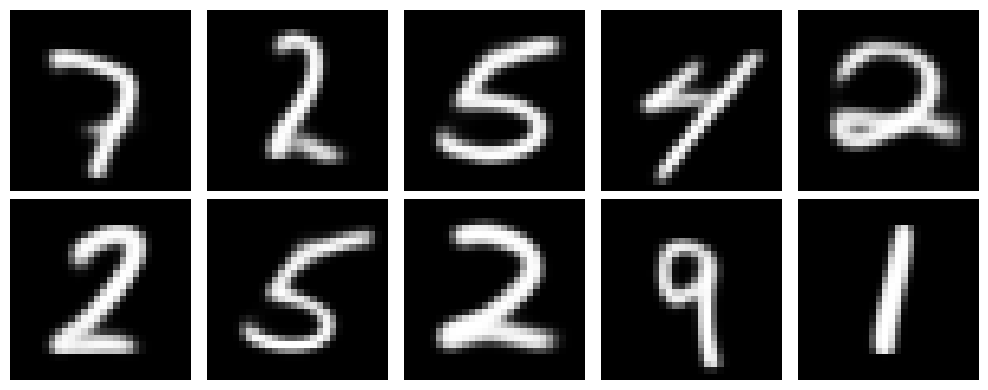

In [70]:
samples = basic.generate_samples(10, 15)
plot_generated(samples)

In [ ]:
## For comparing two flows
x1, x2 = comparative_generate_samples(flow1, flow2, vae, 5, 10)
print("Normal Flow")
plot_generated(x1)
print("Re Flow")
plot_generated(x2)

### Play Eval Time

#### Train flow for final models

##### Vae load

In [5]:
path_to_7x7 = 'models/7x7_epoch_2000.pt'
path_to_49 = 'models/49_epoch_2000.pt'

vae_7x7_config = dict(
    latent_shape=(1, 7, 7),
    base_channels=32,
    blocks_per_level=1,
    groups=4,
    dropout=0.294905,
    act=nn.SiLU
)

vae_49_config = dict(
    latent_shape=49,
    base_channels=32,
    blocks_per_level=1,
    groups=4,
    dropout=0.294905,
    act=nn.SiLU,
)


# Load models, emas, and checkpoints
vae_7x7 = InspoResNetVAE(**vae_7x7_config).to(device)
ema_7x7 = ExponentialMovingAverage(vae_7x7.parameters(), decay=0.9999).to(device)
checkpoint_7x7 = load_checkpoint(path_to_7x7, vae_7x7, ema=ema_7x7, device=device)

vae_49 = InspoResNetVAE(**vae_49_config).to(device)
ema_49 = ExponentialMovingAverage(vae_49.parameters(), decay=0.9999).to(device)
checkpoint_49 = load_checkpoint(path_to_49, vae_49, ema=ema_49, device=device)

Checkpoint loaded: models/7x7_epoch_2000.pt (epoch 2000)
Checkpoint loaded: models/49_epoch_2000.pt (epoch 2000)


##### minor analysis / data encode

vae for 7x7


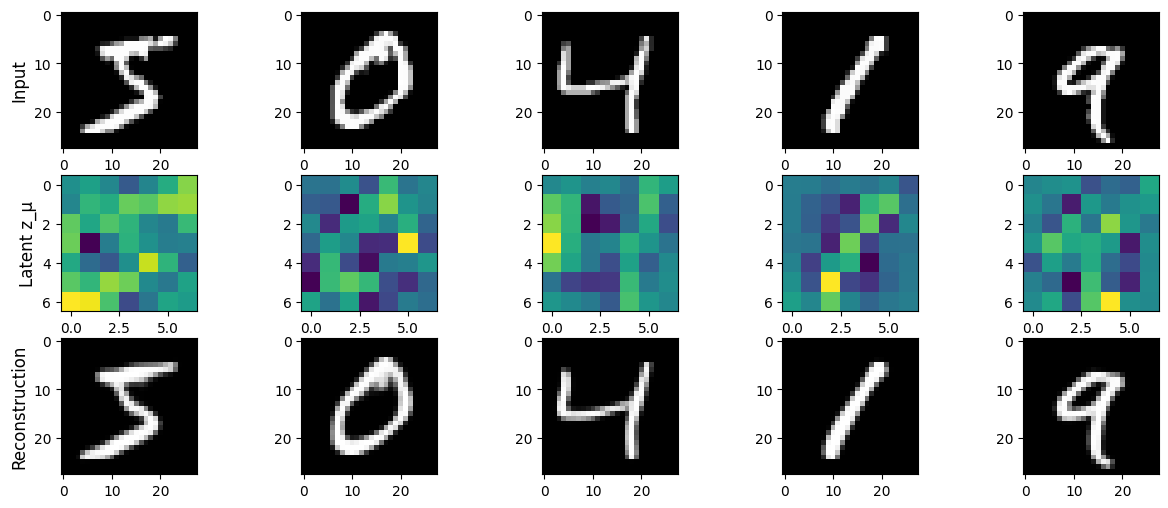


vae for 49


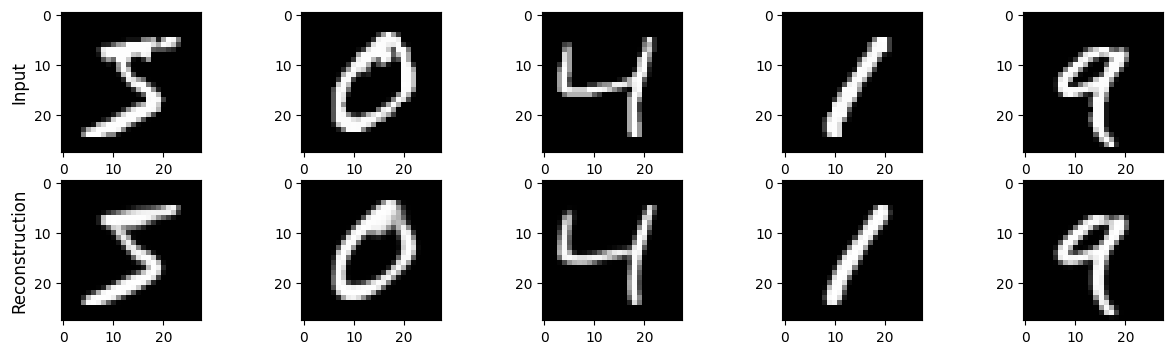

In [7]:
print('vae for 7x7')
test_inference_spatial(vae_7x7, train_ds, range(5))
# plot_latent_space(vae_7x7, test_dl, use_3d=False, reducer='tsne')

print('\nvae for 49')
test_inference(vae_49, train_ds, range(5))
# plot_latent_space(vae_49, test_dl, use_3d=False, reducer='tsne')


In [ ]:
encode_dataset(vae_7x7, train_dl, test_dl, suffix='final', ema=ema_7x7)
encode_dataset(vae_49, train_dl, test_dl, suffix='final', ema=ema_49)

##### Now for flow training

In [6]:
# load latent encoded data lets start with 49
latent_data_path_49 = os.path.join('data', vae_49.encoder.__class__.__name__ + '_' + 'final' + '/MNIST/')
train_ds_49, test_ds_49 = load_encoded_dataset(latent_data_path_49)
train_dl_49 = DataLoader(train_ds_49, batch_size=batch_size, shuffle=True)
test_dl_49  = DataLoader(test_ds_49, batch_size=batch_size, shuffle=False)

# Now 7x7
latent_data_path_7x7 = os.path.join('data', vae_7x7.encoder.__class__.__name__ + '_' + 'final' + '/MNIST/')
train_ds_7x7, test_ds_7x7 = load_encoded_dataset(latent_data_path_7x7)
train_dl_7x7 = DataLoader(train_ds_7x7, batch_size=batch_size, shuffle=True)
test_dl_7x7  = DataLoader(test_ds_7x7, batch_size=batch_size, shuffle=False)

print(f"Loaded 7x7 latent data with shape: {train_dl_7x7.dataset.data.shape}")
print(f"Loaded 49 latent data with shape: {train_dl_49.dataset.data.shape}")

Loaded 7x7 latent data with shape: (60000, 7, 7)
Loaded 49 latent data with shape: (60000, 49)


In [7]:
class LinearResidualBlock(nn.Module):
    """Linear version of ResidualBlock for flat flow models"""
    def __init__(self, dim, use_skip=True, use_ln=True, act=nn.SiLU):
        super().__init__()
        self.fc1 = nn.Linear(dim, dim, bias=not use_ln)
        self.ln1 = nn.LayerNorm(dim) if use_ln else nn.Identity()
        self.fc2 = nn.Linear(dim, dim, bias=not use_ln)
        self.ln2 = nn.LayerNorm(dim) if use_ln else nn.Identity()
        self.use_skip = use_skip
        self.act = act

    def forward(self, x):
        if self.use_skip: x0 = x
        out = self.act()(self.ln1(self.fc1(x)))
        out = self.ln2(self.fc2(out))
        if self.use_skip: out = out + x0
        return self.act()(out)


class InspoFlatVelocityNet(nn.Module):
    """Flat flow model inspired by InspoResNetVAEEncoder architecture"""

    def __init__(self, input_dim, base_channels=64, blocks_per_level=1, use_skips=True, use_ln=True,
                 act=nn.SiLU, groups=1, time_embed_dim=32):
        super().__init__()

        # Time embedding
        self.time_embed = nn.Sequential(
            nn.Linear(1, time_embed_dim),
            act(),
            nn.Linear(time_embed_dim, time_embed_dim)
        )

        # Input projection with time
        self.fc_in = nn.Linear(input_dim + time_embed_dim, base_channels, bias=not use_ln)
        self.ln_in = nn.LayerNorm(base_channels) if use_ln else nn.Identity()

        # Levels with transitions (like InspoResNetVAEEncoder)
        channels = [base_channels, base_channels * 2, base_channels * 4]  # len(channels) = num levels
        self.levels = nn.ModuleList(
            [nn.ModuleList([LinearResidualBlock(ch, use_skips, use_ln, act=act)
                           for _ in range(blocks_per_level)])
             for ch in channels])
        self.transitions = nn.ModuleList(
            [nn.Linear(channels[i], channels[i + 1], bias=not use_ln) for i in range(len(channels) - 1)])

        # Output projection
        self.fc_out = nn.Linear(base_channels * 4, input_dim)

        self.act = act
        self.groups = groups

    def forward(self, x, t):
        # Time embedding
        t = t.expand(x.size(0), 1)
        t_embed = self.time_embed(t)

        # Concatenate input with time embedding
        x = torch.cat([x, t_embed], dim=-1)

        # Input projection
        x = self.act()(self.ln_in(self.fc_in(x)))

        # Process through levels with transitions
        for i in range(len(self.levels)):
            if i > 0:  # transition to next level
                x = self.transitions[i - 1](x)
            for block in self.levels[i]:
                x = block(x)

        # Output projection
        return self.fc_out(x)

In [32]:
# flow_49 = FlatVelocityNet(49)

# flow_config = dict(
#     learning_rate=1e-3,
#     weight_decay=0.0,
#     epochs=10,
#     batch_size=128,
#     n_steps=20,
#     use_time_warp=False,
#     reflow_every=0,  # 0 = no reflow, >0 = reflow every N steps
# )

flow_49 = InspoFlatVelocityNet(
    input_dim=49,
    base_channels=32,
    blocks_per_level=1,
    use_skips=True,
    use_ln=True

)

flow_config = dict(
    learning_rate=1e-3,
    weight_decay=0.0,
    epochs=10,
    batch_size=128,
    n_steps=20,
    use_time_warp=False,
    reflow_every=0,  # 0 = no reflow, >0 = reflow every N steps
)

total_params = sum(p.numel() for p in flow_49.parameters())
trainable_params = sum(p.numel() for p in flow_49.parameters() if p.requires_grad)
print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 64241
Trainable parameters: 64241


In [15]:
import copy
parent = copy.deepcopy(flow_49)

In [33]:
flow_train(flow_49, train_dl_49, test_dl_49, config=flow_config
           # , pretrained_model=parent
          )

Using device: cuda
Training InspoFlatVelocityNet with 64,241 parameters
Latent data shape: torch.Size([128, 49]), spatial: False


Model saved to: E:\Pycharm\dl_class_projects\dl_experimentation\models/safetensors/flow/standalone\lunar-bird-44.safetensors


cos_sim,▁▂▃▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█▇▇██▇██▇▇████████
drift_norm,▁▃▄▅▆▆▅▅▅▆▆▆▆▆▇▇▇█▇▆▇█▇▇▇▇▇████▇▇██▇▇██▇
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▆▆▆▆▆▇▇▇▇▇███
step,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇█████
train_loss,█▇▅▆▆▆▄▄▅▆▄▅▂▃▃▃▅▃▂▄▃▃▄▂▁▄▃▃▃▃▃▂▃▃▃▁▂▂▃▃
val_cos_sim,▁█
val_loss,█▁
cos_sim,0.44939
drift_norm,4.0044
epoch,10
step,4689


InspoFlatVelocityNet(
  (time_embed): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): SiLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
  )
  (fc_in): Linear(in_features=81, out_features=32, bias=False)
  (ln_in): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (levels): ModuleList(
    (0): ModuleList(
      (0): LinearResidualBlock(
        (fc1): Linear(in_features=32, out_features=32, bias=False)
        (ln1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (fc2): Linear(in_features=32, out_features=32, bias=False)
        (ln2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      )
    )
    (1): ModuleList(
      (0): LinearResidualBlock(
        (fc1): Linear(in_features=64, out_features=64, bias=False)
        (ln1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (fc2): Linear(in_features=64, out_features=64, bias=False)
        (ln2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)


In [34]:
basic = BasicModel(vae_49, flow_49, (49,)).to(device)

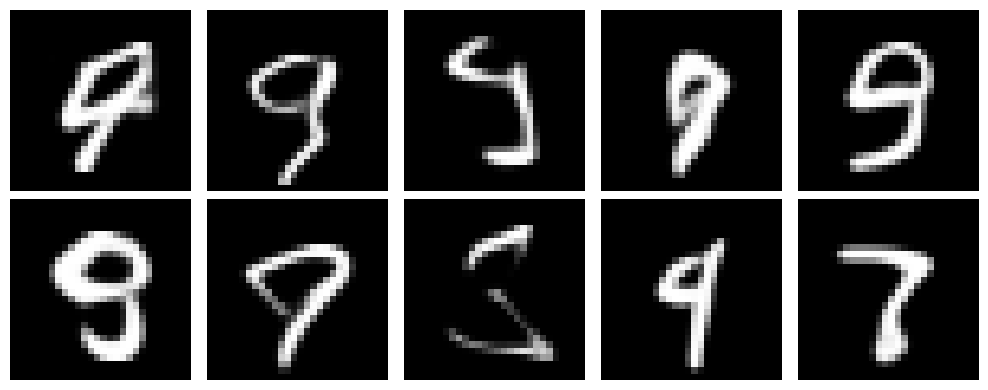

In [35]:
samples = basic.generate_samples(10, 15)
plot_generated(samples)

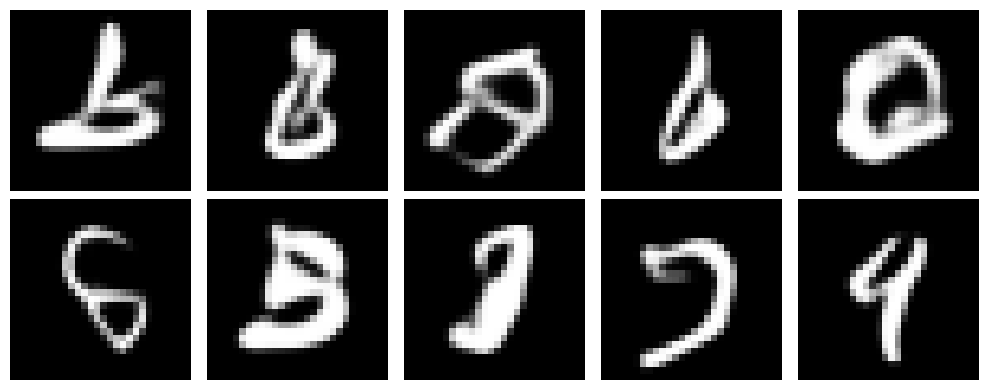

In [24]:
samples = basic.generate_samples(10, 15)
plot_generated(samples)

#### Old Play

In [4]:
# dainty-sweep-158 (cjugxj69)
dainty_sweep = dict(
    latent_shape=(49,),
    base_channels=32,
    blocks_per_level=1,
    groups=4,
    dropout=0.294905,
    act=nn.SiLU,

    # batch_size=128,
    # learning_rate=0.004303,
    # weight_decay=0.000039,
    # epochs=25,

    # beta_final=0.105,
    # warmup_epochs=5,
    # ema=0.97,
)

# silver-sweep-152 (yd9u1vxj)
silver_sweep = dict(
    latent_shape=(49,),
    base_channels=32,
    blocks_per_level=2,
    groups=1,
    dropout=0.235134,
    act=nn.SiLU,

    # batch_size=128,
    # learning_rate=0.000764,
    # weight_decay=0.000085,
    # epochs=25,

    # beta_final=0.105,
    # warmup_epochs=5,
    # ema=0.97,
)

# stoic-sweep-74 (k8btel7f)
stoic_sweep = dict(
    latent_shape=(49,),
    base_channels=32,
    blocks_per_level=3,
    groups=1,
    dropout=0.218544,
    act=nn.GELU,

    # batch_size=128,
    # learning_rate=0.000595,
    # weight_decay=0.000041,
    # epochs=25,

    # beta_final=0.105,
    # warmup_epochs=5,
    # ema=0.97,
)

# earthy-sweep-151 (bzkr37oe)
earthy_sweep = dict(
    latent_shape=(49,),
    base_channels=24,
    blocks_per_level=1,
    groups=4,
    dropout=0.327277,
    act=nn.GELU,

    # batch_size=128,
    # learning_rate=0.009207,
    # weight_decay=0.000002,
    # epochs=25,

    # beta_final=0.105,
    # warmup_epochs=5,
    # ema=0.97,
)

# glowing-sweep-110 (zf81gxm4)
glowing_sweep = dict(
    latent_shape=(49,),
    base_channels=16,
    blocks_per_level=3,
    groups=4,
    dropout=0.432183,
    act=nn.ReLU,

    # batch_size=128,
    # learning_rate=0.007816,
    # weight_decay=0.000016,
    # epochs=25,

    # beta_final=0.105,
    # warmup_epochs=5,
    # ema=0.97,
)

In [5]:
loaded_vaes = []
configs_to_load = [dainty_sweep, silver_sweep, stoic_sweep, earthy_sweep, glowing_sweep]
names = ['dainty-sweep','silver-sweep', 'stoic-sweep', 'earthy-sweep', 'glowing-sweep']

for i, config in enumerate(configs_to_load):
    loaded_vae = InspoResNetVAE(**configs_to_load[i]).to(device)
    vae_path = f'/Users/marcocassar/Projects/DLAIE/self/dl_experimentation/models/safetensors/vae/6_trained/standalone_{names[i]}.safetensors'
    loaded_vae.load_state_dict(load_file(vae_path))
    loaded_vaes.append(loaded_vae)

In [ ]:
for i, vae_ in enumerate(loaded_vaes):
    print(f"Vae: {names[i]}")
    display(plot_latent_space(vae_, test_dl, use_3d=False, reducer='tsne'))

# Encode each
for i, vae_ in enumerate(loaded_vaes):
    print(f"Vae: {names[i]}")
    vae_.eval()
    suffix = create_model_suffix(configs_to_load[i])
    print(f"Using suffix: {suffix}")
    encode_dataset(vae_, train_dl, test_dl, suffix=suffix)

def load_and_train(vae_model, flow_model, suffix, flow_name=None, pretrained_flow_model=None, epochs=5):
    latent_data_path = os.path.join('data', vae_model.encoder.__class__.__name__ + '_' + suffix + '/MNIST/')
    latent_train_ds, latent_test_ds = load_encoded_dataset(latent_data_path)
    latent_train_dl = DataLoader(latent_train_ds, batch_size=batch_size, shuffle=True)
    latent_test_dl  = DataLoader(latent_test_ds, batch_size=batch_size, shuffle=False)

    if not flow_name: flow_name = suffix

    train_flow(flow_model, latent_train_dl, latent_test_dl, name=flow_name, pretrained_model=pretrained_flow_model, epochs=epochs, spatial=False)

In [41]:
flow_models = []
for i, vae_ in enumerate(loaded_vaes):
    suffix = create_model_suffix(configs_to_load[i])
    name = names[i]
    flow_models.append(FlatVelocityNet(vae_.latent_dim).to(device))
    load_and_train(vae_, flow_models[i], suffix, flow_name=name, epochs=100)

cos_sim,▁▃▃▃▃▄▃▄▆▆▅▆▆▆▆▇▆▆▆█▇▇▇▇▇▇▇▇▇▇███▇█▇▇▇▇█
drift,▁▂▃▂▃▃▄▄▅▅▅▆▆▇▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
step,▁▁▁▁▁▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train_loss,█▇▇█▆▅▄▄▄▄▃▃▃▃▂▃▃▁▃▃▂▂▂▂▃▃▄▃▂▃▂▂▂▂▂▁▄▃▂▂
cos_sim,0.58586
drift,5.12682
step,46900
train_loss,1.08055


cos_sim,▁▃▃▄▄▅▅▅▆▅▆▅▅▅▆▆▆▆▆▆▆▆▇▅▆▇▆▇▇▆██▇▆▇▆▆█▆▇
drift,▁▂▃▄▄▄▅▆▆▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇██▇██
step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇██
train_loss,█▇▇▅▆▆▅▅▃▄▄▆▆▃▄▃▃▃▃▃▄▂▁▃▃▂▃▃▂▃▃▂▂▃▂▂▁▄▂▁
cos_sim,0.59158
drift,5.27407
step,46900
train_loss,1.0518


cos_sim,▁▂▂▄▃▄▄▃▆▆▅▆▅▅▅▅▆▆▆▅▇▆▆▆█▆▇▇▆▆█▆▆▇▅▆▇██▆
drift,▁▂▄▄▄▅▅▅▅▆▆▆▇▆▆▆▆▇▆▆▆▇▇▆▆▇▇▇▇▇██▇▇▇▇▇▇▇▇
step,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇██
train_loss,█▄▃▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▂▁▂▁▂▂▁▂▂▁▂▁▁▁▂▁▁▁▁▂
cos_sim,0.60802
drift,5.23447
step,46900
train_loss,0.98634


cos_sim,▁▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇█▇█▇█████▇█
drift,▁▂▃▄▅▆▆▇▆▇▇▆▇▆▇▇▇▇▇▇███▇█▇█▇██▇▇▇█▇██▇██
step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇▇████
train_loss,▇█▆▆▆▅▅▄▆▄▄▄▅▃▃▄▃▄▂▄▃▃▄▂▃▂▃▃▂▃▄▃▃▄▃▁▂▃▁▂
cos_sim,0.579
drift,5.19974
step,46900
train_loss,1.12348


In [42]:
for i, flow_ in enumerate(flow_models):
    flow_name = names[i]
    flow_save_name =  f'{flow_.__class__.__name__}_{flow_name}'
    flow_path = os.path.join(model_save_path, f'flow/{flow_save_name}.safetensors')
    if os.path.exists(flow_path):
        print(f"Path: {flow_path} \n already exists! Breaking!")
        break
        # flow_path = flow_path.split('.safetensors')[0] + str(wandb.run.id) + '.safetensors'
    print(f"Saving to: {flow_path}")
    save_file(flow_.state_dict(), flow_path)

Saving to: models/safetensors/flow/FlatVelocityNet_dainty-sweep.safetensors
Saving to: models/safetensors/flow/FlatVelocityNet_silver-sweep.safetensors
Saving to: models/safetensors/flow/FlatVelocityNet_stoic-sweep.safetensors
Saving to: models/safetensors/flow/FlatVelocityNet_earthy-sweep.safetensors
Saving to: models/safetensors/flow/FlatVelocityNet_glowing-sweep.safetensors
